In [2]:
import pandas as pd
from xml.etree import ElementTree
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras import layers
from keras import models
from collections import Counter
from math import ceil, floor
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger
from keras.layers import Dropout, Conv3D, BatchNormalization, MaxPooling2D , Activation, MaxPooling3D
import os
import matplotlib.pyplot as plt
from keras.layers import TimeDistributed, LSTM, Dense, ConvLSTM2D, Bidirectional
import pickle

In [3]:
vid_names = ['movie1gel1', 'movie1gel2', 'movie2gel1', 'movie2gel2', 'movie3gel1', 'movie3gel2']
conc = {0: 0.2, 1: 0.28, 2: 0.36, 3: 0.44, 4: 0.52, 5: 0.6, 6: 0.68, 7: 0.76, 8: 0.84, 9: 0.92, 10: 1}
conc_reverse = dict(map(reversed,conc.items()))

In [4]:
train_vids = ['movie1gel1', 'movie2gel1', 'movie3gel1', 'movie3gel2']
train_paths = list()

no_files = 0
for vid in train_vids:
    for i in range(11):
        no_files += len(os.listdir('sequences_per_video_100x100/'+vid+'/'+str(i)))
        for file in os.listdir('sequences_per_video_100x100/'+vid+'/'+str(i)):
            train_paths.append('sequences_per_video_100x100/'+vid+'/'+str(i)+'/'+file)
        
def batch_generator_from_memory(train_files, batch_size = 100):
    indices = np.arange(len(train_files))
    X = list()
    Y = list()
    while True:
        np.random.shuffle(indices)
        for i in indices:
            aux = np.load(train_files[i], allow_pickle = True)
            X.append(aux[0]/255)
            Y.append(aux[1])
            if len(X)==batch_size:
                yield np.asarray(X), np.asarray(Y)
                X = list()
                Y = list()

In [5]:
val_vids = ['movie1gel2']
val_paths = list()

no_val_files = 0
for vid in val_vids:
    for i in range(11):
        no_val_files += len(os.listdir('sequences_per_video_100x100/'+vid+'/'+str(i)))
        for file in os.listdir('sequences_per_video_100x100/'+vid+'/'+str(i)):
            val_paths.append('sequences_per_video_100x100/'+vid+'/'+str(i)+'/'+file)

def validation_generator(train_files, batch_size = 1):
    indices = np.arange(len(train_files))
    X = list()
    Y = list()
    while True:
        for i in indices:
            aux = np.load(train_files[i], allow_pickle = True)
            X.append(aux[0]/255)
            Y.append(aux[1])
            if len(X)==batch_size:
                yield np.asarray(X), np.asarray(Y)
                X = list()
                Y = list()

In [6]:
#CONVOLUTION 3D dimension always twenty 
def lenet_model_custom(channels, filters_width, dropout_rate, dense_length):
    model = models.Sequential()
    model.add(Conv3D(channels[0], (filters_width[0], filters_width[1], filters_width[2]), input_shape=(78, 100, 100, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))   
    model.add(MaxPooling3D((2, 2, 2), strides = 2))
    model.add(Dropout(dropout_rate))
    model.add(Conv3D(channels[1], (filters_width[0], filters_width[1], filters_width[2])))
    model.add(BatchNormalization())
    model.add(Activation('relu')) 
    model.add(MaxPooling3D((2, 2, 2), strides = 2))
    model.add(Dropout(dropout_rate))
    model.add(layers.Flatten())
    model.add(layers.Dense(dense_length))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(layers.Dense(1))
    
    model.summary()
    return model

In [7]:
#GRID SEARCH
channels = [(16,32)]
filters_width = [(10,10,10),(15,15,15), (15,10,10)]
dropout = [0.2, 0.35, 0.5]

params = list()
for c in channels:
    for fw in filters_width:
        for d in dropout:
            params.append([c,fw,d,32])

In [8]:
params

[[(16, 32), (10, 10, 10), 0.2, 32],
 [(16, 32), (10, 10, 10), 0.35, 32],
 [(16, 32), (10, 10, 10), 0.5, 32],
 [(16, 32), (15, 15, 15), 0.2, 32],
 [(16, 32), (15, 15, 15), 0.35, 32],
 [(16, 32), (15, 15, 15), 0.5, 32],
 [(16, 32), (15, 10, 10), 0.2, 32],
 [(16, 32), (15, 10, 10), 0.35, 32],
 [(16, 32), (15, 10, 10), 0.5, 32]]

In [9]:
batch_size = 17
num_samples = no_files

for i in [4,6,7]:
    model = lenet_model_custom(params[i][0], params[i][1], params[i][2], params[i][3])
    save_folder = './CNN3D_orig_regression_logs_changed_sets/lenet_custom_'+ str(i)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
    csv = CSVLogger(save_folder +'/training.log')
    tb = TensorBoard(update_freq='epoch', log_dir = save_folder)
    weigths_name="best_weights.h5"
    mc = ModelCheckpoint(save_folder+'/'+weigths_name, monitor='val_loss', mode='min', save_best_only=True)
    cbs = [mc, es, tb, csv]
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
    history = model.fit_generator(batch_generator_from_memory(train_paths, batch_size = batch_size), 
              steps_per_epoch = ceil(num_samples / batch_size), epochs = 1000, validation_data = validation_generator(val_paths), validation_steps = no_val_files, 
              callbacks = cbs)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 64, 86, 86, 16)    162016    
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 86, 86, 16)    64        
_________________________________________________________________
activation_1 (Activation)    (None, 64, 86, 86, 16)    0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 32, 43, 43, 16)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 43, 43, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)    

Epoch 1/1000
266/266 [==============================] - 1018s 4s/step - loss: 0.3822 - mean_absolute_error: 0.3948 - val_loss: 0.0349 - val_mean_absolute_error: 0.1490
Epoch 2/1000
266/266 [==============================] - 994s 4s/step - loss: 0.0295 - mean_absolute_error: 0.1368 - val_loss: 0.0222 - val_mean_absolute_error: 0.1179
Epoch 3/1000
266/266 [==============================] - 994s 4s/step - loss: 0.0216 - mean_absolute_error: 0.1172 - val_loss: 0.0217 - val_mean_absolute_error: 0.1187
Epoch 4/1000
266/266 [==============================] - 994s 4s/step - loss: 0.0190 - mean_absolute_error: 0.1102 - val_loss: 0.0332 - val_mean_absolute_error: 0.1470
Epoch 5/1000
266/266 [==============================] - 994s 4s/step - loss: 0.0162 - mean_absolute_error: 0.1023 - val_loss: 0.0350 - val_mean_absolute_error: 0.1555
Epoch 6/1000
266/266 [==============================] - 994s 4s/step - loss: 0.0138 - mean_absolute_error: 0.0929 - val_loss: 0.0266 - val_mean_absolute_error: 0.13

# YOLO

In [16]:
#NAAAAOOOOO CORRER MAAAAAAAAAAIS##########################
val_preds = {}
sizes = {}

for model_ in ['lenet_custom_6']:
    print(model_)
    val_preds[model_] = {}
    sizes[model_] = {}
    for i in range(11):
        print(i)
        cur_path = 'sequences_per_video_100x100/movie2gel2/'+str(i)
        seqs = list()
        sizes_list = list()
        for file in sorted(os.listdir(cur_path)):
            aux = np.load(cur_path+'/'+file, allow_pickle = True)
            seqs.append(aux[0]/255)
            sizes_list.append(aux[2])
        model = models.load_model('CNN3D_orig_regression_logs_changed_sets/'+model_+'/best_weights.h5')
        val_preds[model_][i] = model.predict(np.asarray(seqs))
        sizes[model_][i] = sizes_list

lenet_custom_6
0
1
2
3
4
5
6
7
8
9
10


In [17]:
#with open('YOLO_preds_CNN3D_orig_changed_sets.pkl', 'wb') as f:
#    pickle.dump((val_preds, sizes), f)
    
    
with open('YOLO_preds_CNN3D_orig_changed_sets.pkl', 'rb') as f: 
    aux = pickle.load(f)
    
val_preds = aux[0]
sizes = aux[1]

In [18]:
#mse per model per conc
mse_cat = {}

for model_ in val_preds:
    mse_cat[model_] = {}
    for i in range(11):
        mse_cat[model_][i] = 0
        for j in range(len(val_preds[model_][i])):
            mse_cat[model_][i] += (conc[i] - val_preds[model_][i][j][0]) ** 2
        mse_cat[model_][i] /= len(val_preds[model_][i])

In [19]:
#mse per conc (mean between all models)
mse_conc = {}

for i in range(11):
    mse_conc[i] = 0

for key in mse_cat:
    for i in range(11):
        mse_conc[i] += mse_cat[key][i]
        
for key in mse_conc:
    mse_conc[key] /= len(mse_cat.keys())

In [20]:
mean_preds = {}
for mod in val_preds:
    mean_preds[mod] = list()
    for i in range(11):
        aux = 0
        for j in range(len(val_preds[mod][i])):
            aux += val_preds[mod][i][j][0]
        mean_preds[mod].append(aux / len(val_preds[mod][i]))

In [21]:
preds_clean = {}
preds_clean['x'] = list()
preds_clean['y'] = list()

for i in val_preds['lenet_custom_6']:
    for j in val_preds['lenet_custom_6'][i]:
        preds_clean['x'].append(conc[i])
        preds_clean['y'].append(j[0])

In [22]:
abs_mean_error = list()
for i in range(len(mean_preds['lenet_custom_6'])):
    abs_mean_error.append(abs(mean_preds['lenet_custom_6'][i] - conc[i]))
abs_mean_error

[0.048655050541415334,
 0.0037738860827504217,
 0.0016123019474925115,
 0.04460639922907855,
 0.07504217872252827,
 0.06506550725429294,
 0.04235901605698367,
 0.010247179654336747,
 0.018430566326264497,
 0.011291716997740675,
 0.05931326698084349]

In [23]:
val_mae = list()
for i in range(len(preds_clean['x'])):
    val_mae.append(abs(preds_clean['x'][i] - preds_clean['y'][i]))
    
val_mae = np.mean(val_mae)
val_mae

0.06367669970863025

In [24]:
concs_real = list()

for i in range(11):
    concs_real.append(conc[i])

No handles with labels found to put in legend.


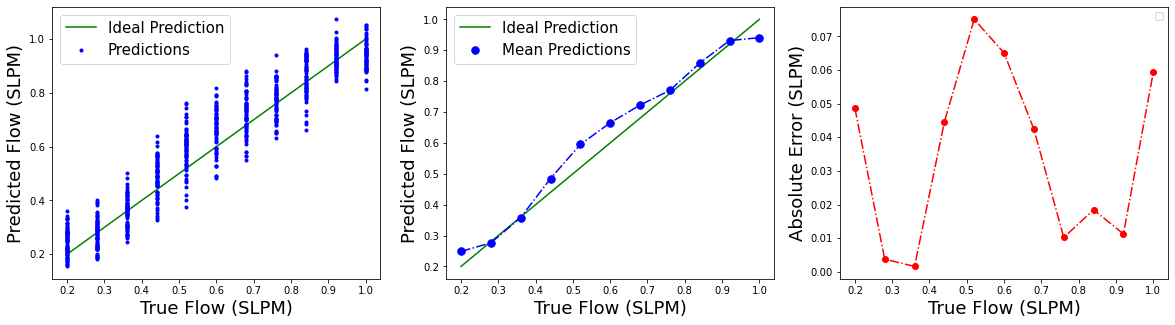

In [25]:
fig, axs = plt.subplots(1,3, figsize=(20,5))
mod = 'lenet_custom_6'
fs = 18

axs[0].plot(concs_real, concs_real, 'g', label = 'Ideal Prediction')

axs[0].plot(preds_clean['x'], preds_clean['y'], 'bo', markersize=3, label = 'Predictions')
        
axs[1].plot(concs_real, concs_real, 'g', label = 'Ideal Prediction')
axs[1].plot(concs_real, mean_preds[mod], 'b-.')
axs[1].plot(concs_real, mean_preds[mod], 'b.', markersize=15, label = 'Mean Predictions')

axs[0].legend(loc=0, fontsize=15)
axs[1].legend(loc=0, fontsize=15)
axs[2].legend(loc=0)
axs[0].set_xlabel('True Flow (SLPM)', fontsize = fs)
axs[0].set_ylabel('Predicted Flow (SLPM)', fontsize = fs)
axs[1].set_xlabel('True Flow (SLPM)', fontsize = fs)
axs[1].set_ylabel('Predicted Flow (SLPM)', fontsize = fs)
axs[2].set_xlabel('True Flow (SLPM)', fontsize = fs)
axs[2].set_ylabel('Absolute Error (SLPM)', fontsize = fs)

axs[2].plot(concs_real, abs_mean_error, 'r-.')
axs[2].plot(concs_real, abs_mean_error, 'ro')

In [26]:
with open('YOLO_CNN3D_orig_changed_sets_ALL_VARIABLES.pkl', 'wb') as f:
    pickle.dump((mse_cat, mse_conc, mean_preds, preds_clean, abs_mean_error, val_mae), f)